In [72]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import matplotlib.ticker as ticker
import numpy as np

def parse_filename(filename):
    """Extracts workers and threads from the filename using regex."""
    match = re.search(r'workers_(\d+)_threads_(\d+)_users_(\d+)_payload_(\d+)_policies_(\d+)_detailed.csv', filename)
    if match:
        workers = int(match.group(1))
        threads = int(match.group(2))
        users = int(match.group(3))
        payload_size = int(match.group(4))
        policies = int(match.group(5))
        return workers, threads, users, payload_size, policies
    return None, None, None, None, None


def load_and_process_files(folder_path):
    """Loads all *detailed.csv files, extracts worker/thread counts, and concatenates the data, filtering out aggregated results."""
    all_data = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith("detailed.csv"):
            workers, threads, users, payload_size, policies = parse_filename(filename)
            if workers is not None and threads is not None:
                file_path = os.path.join(folder_path, filename)
                # df = pd.read_csv(file_path, usecols=["Name", "Start Time", "Response Time (ms)", "Status Code", "Exception", "Payload Size ", "Cryptographed Payload Size (bytes)", "Cryptographed Key Size (bytes)", "User Key Size (bytes)", "User Attributes"])
                df = pd.read_csv(file_path)
                df = df[df["Name"] != "Aggregated"]
                df["Workers"] = workers
                df["Threads"] = threads
                df["Users"] = users
                df["Payload Size"] = payload_size
                df["Policies"] = policies

                all_data.append(df)
    
    if not all_data:
        raise ValueError("No valid locust stats history files found in the folder.")
    
    return pd.concat(all_data, ignore_index=True)

In [73]:
phase1 = load_and_process_files("./test_results/20250319_100243T10m")
phase1

EmptyDataError: No columns to parse from file

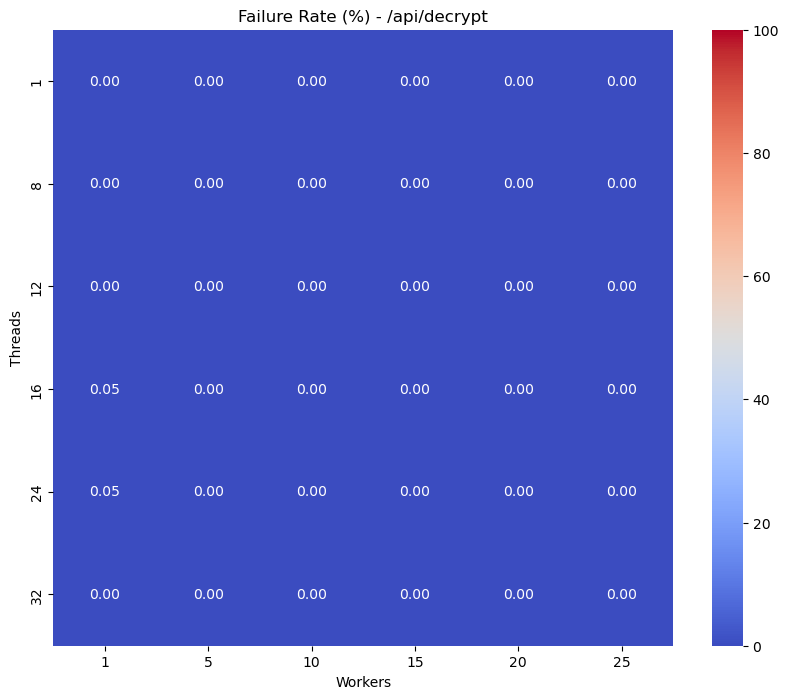

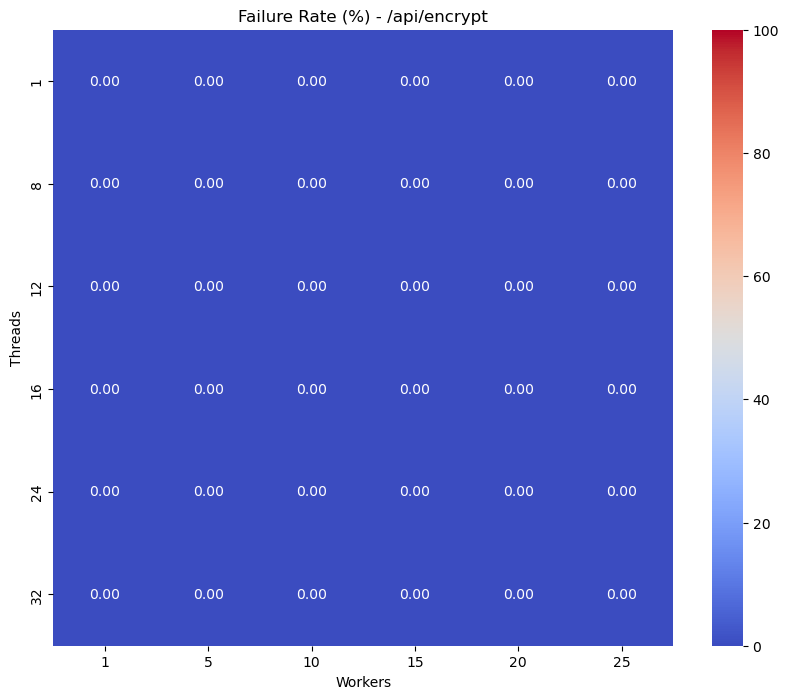

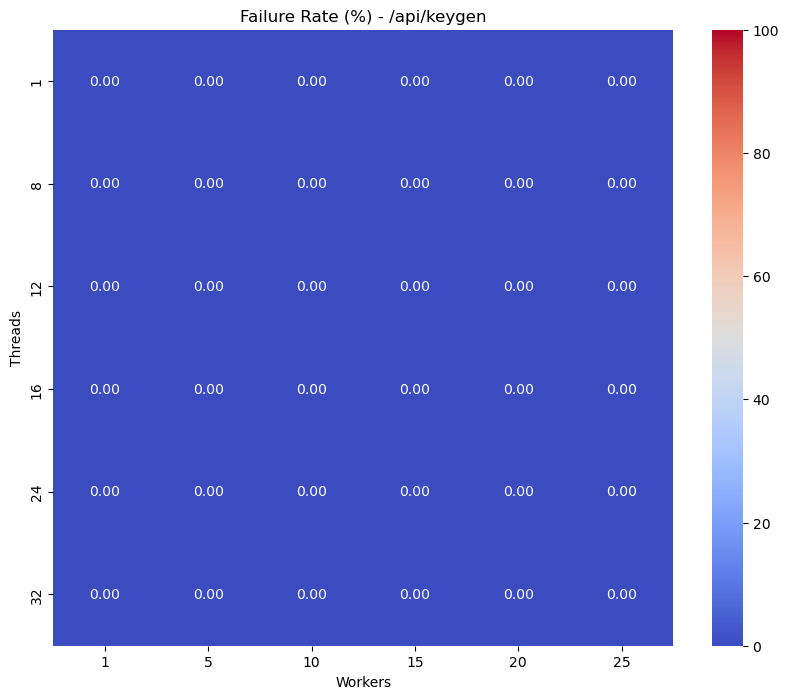

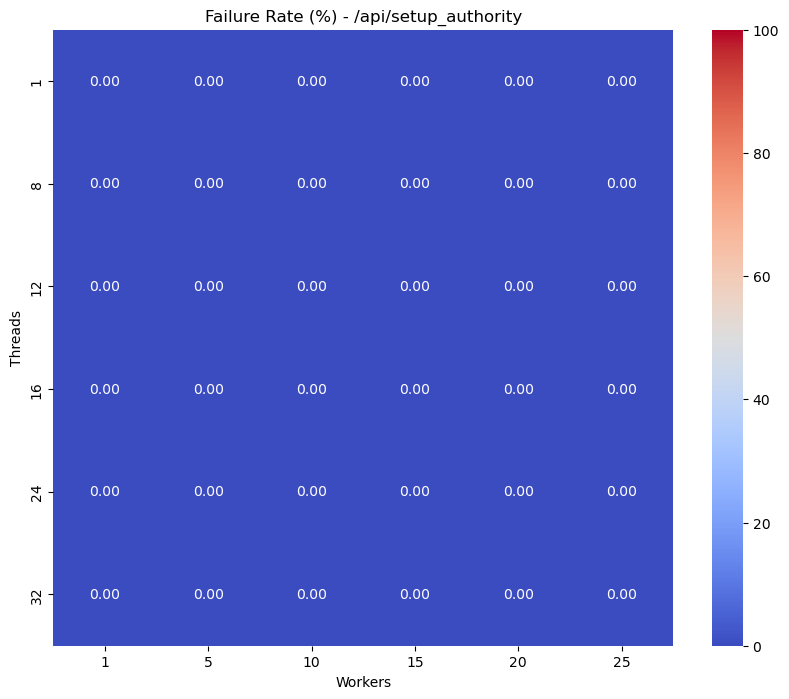

In [ ]:
## Generate heatmap of failure rates

data = phase1.copy()
# Remove all status code 0 entries (failed requests)
data = data[data["Status Code"] != 0]

# Create a copy to avoid SettingWithCopyWarning
data = data.copy()

# Identify failures based on status code 5xx in the Exception column
data.loc[:, "Failure"] = data["Exception"].fillna("").str.startswith("5")

# Group by endpoint, workers, and threads
grouped = data.groupby(["Name", "Workers", "Threads"]).agg(
    Total_Requests=("Name", "count"),
    Total_Failures=("Failure", "sum")
).reset_index()

# Calculate failure rate as percentage
grouped.loc[:, "Failure Rate"] = (grouped["Total_Failures"] / grouped["Total_Requests"]) * 100

# Get all unique API endpoints from the Name column
unique_endpoints = grouped["Name"].unique()

# Generate a heatmap for each API endpoint
for endpoint in unique_endpoints:
    df_filtered = grouped[grouped["Name"] == endpoint]  # Filter data for the current endpoint

    pivot_table = df_filtered.pivot_table(values="Failure Rate", index="Threads", columns="Workers", aggfunc="mean")

    plt.figure(figsize=(10, 8))  # Set figure size
    sns.heatmap(pivot_table, annot=True, cmap="coolwarm", fmt=".2f", vmin=0, vmax=100)  # Create heatmap
    plt.title(f"Failure Rate (%) - {endpoint}")  # Set title
    plt.xlabel("Workers")  # Label x-axis
    plt.ylabel("Threads")  # Label y-axis

    os.makedirs("./images/phase1", exist_ok=True)
    output_path = os.path.join("./images/phase1", f"failure_rate_{endpoint.replace('/', '_')}.png")
    plt.savefig(output_path)

In [ ]:
plt.close()

In [ ]:
## Generate boxplots and summary statistics for response time across 
## different workers/threads configurations for each API endpoint. 
## Filters out any result with status code different from 2xx.

# Filter only successful responses (2xx status codes)
from turtle import color
from matplotlib.ticker import FixedFormatter


data = data[data["Status Code"].astype(str).str.startswith("2")]

# Create a directory to save plots if it doesn't exist
# output_dir = os.path.join(folder_path, "analysis")
output_dir = "./images/phase1"
os.makedirs(output_dir, exist_ok=True)

# Set plot style
sns.set_theme(
    context="paper",
    style="whitegrid",
    rc={
        "ytick.minor.visible": True,
        "xtick.minor.visible": True
    }
)

# Generate and save boxplots for each API endpoint
for endpoint in data["Name"].unique():
    endpoint_dir = os.path.join(output_dir, endpoint.strip('/').replace('/', '_'))
    os.makedirs(endpoint_dir, exist_ok=True)

    subset = data[data["Name"] == endpoint]
    plot_data = []

    # Generate plots varying workers for each thread count
    for thread_count in subset["Threads"].unique():
        thread_subset = subset[subset["Threads"] == thread_count]
        title = f"Threads={thread_count}"
        plot_data.append((title, "Workers", thread_subset))

        plt.figure(figsize=(12, 6))
        sns.boxplot(x="Workers", y="Response Time (ms)", data=thread_subset)
        plt.title(f"Response Time Analysis for {endpoint} (Threads={thread_count})")
        plt.xlabel("Number of Workers")
        plt.ylabel("Response Time (ms)")
        plt.yscale("log")
        # class MinorFormatterSciNotation(ticker.Formatter):
        #     SUPERSCRIPT_MAP = str.maketrans('-0123456789', '⁻⁰¹²³⁴⁵⁶⁷⁸⁹')

        #     def __call__(self, x, pos=None):
        #         if x == 0:
        #             return "0"
        #         exponent = int(np.floor(np.log10(x)))
        #         base = x / (10 ** exponent)
        #         # Translate the exponent to superscript
        #         exponent_str = str(exponent).translate(self.SUPERSCRIPT_MAP)
        #         return f"{base:.1f}×10{exponent_str}"

        # plt.gca().yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=[1.5, 2.0, 3.0, 4.0, 6.0, 8.0], numticks=10))
        # plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())
        # plt.gca().yaxis.set_minor_formatter(ticker.ScalarFormatter())
        plt.gca().yaxis.set_tick_params(which='minor', width=0.8, size=4)
        plt.gca().grid(axis='y', which='major', color='gray', linestyle='-', linewidth=1, alpha=1)
        plt.gca().grid(axis='y', which='minor', color='gray', linestyle=':', linewidth=0.9, alpha=0.8)




        # Save the plot
        plot_path = os.path.join(endpoint_dir, f"response_time_threads_{thread_count}.png")
        plt.savefig(plot_path)
        plt.close()

    plot_data.sort(key=lambda x: x[2]["Threads"].iloc[0])
    if plot_data:
        cols = 2  # Define number of columns
        rows = (len(plot_data) + 1) // cols  # Define number of rows for grid layout

        fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4))
        fig.suptitle(f"Response Time Analysis for {endpoint}")
        axes = axes.flatten()  # Flatten in case of single row

        for i, (title, x_label, plot_subset) in enumerate(plot_data):
            sns.boxplot(x=x_label, y="Response Time (ms)", data=plot_subset, ax=axes[i])
            axes[i].set_title(title)
            axes[i].set_xlabel(x_label)
            axes[i].set_ylabel("Response Time (ms)")
            axes[i].set_yscale("log")
            # axes[i].yaxis.set_tick_params(which='minor', width=0.8, size=4)
            # axes[i].grid(axis='y', which='major', color='gray', linestyle='-', linewidth=1, alpha=1)
            # axes[i].grid(axis='y', which='minor', color='gray', linestyle=':', linewidth=0.9, alpha=0.8)

        # Remove any unused subplots in case of odd number of plots
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])


        plt.tight_layout()
        combined_plot_path = os.path.join(endpoint_dir, "response_time_threads_summary.png")
        plt.savefig(combined_plot_path)
        plt.close()

    plot_data.clear()

    # Generate plots varying threads for each worker count
    for worker_count in subset["Workers"].unique():
        worker_subset = subset[subset["Workers"] == worker_count]
        title = f"Workers={worker_count}"
        plot_data.append((title, "Threads", worker_subset))

        plt.figure(figsize=(12, 6))
        sns.boxplot(x="Threads", y="Response Time (ms)", data=worker_subset)
        plt.title(f"Response Time Analysis for {endpoint} (Workers={worker_count})")
        plt.xlabel("Number of Threads")
        plt.ylabel("Response Time (ms)")

        # Save the plot
        plot_path = os.path.join(endpoint_dir, f"response_time_workers_{worker_count}.png")
        plt.savefig(plot_path)
        plt.close()

    plot_data.sort(key=lambda x: x[2]["Workers"].iloc[0])
    if plot_data:
        cols = 2  # Define number of columns
        rows = (len(plot_data) + 1) // cols  # Define number of rows for grid layout

        fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4))
        fig.suptitle(f"Response Time Analysis for {endpoint}")
        axes = axes.flatten()  # Flatten in case of single row

        for i, (title, x_label, plot_subset) in enumerate(plot_data):
            sns.boxplot(x=x_label, y="Response Time (ms)", data=plot_subset, ax=axes[i])
            axes[i].set_title(title)
            axes[i].set_xlabel(x_label)
            axes[i].set_ylabel("Response Time (ms)")

        # Remove any unused subplots in case of odd number of plots
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        combined_plot_path = os.path.join(endpoint_dir, "response_time_workers_summary.png")
        plt.savefig(combined_plot_path)
        plt.close()


In [ ]:
## Phase 1: Summary of the results for each API endpoint

data["Start Time"] = pd.to_datetime(data["Start Time"], unit='s')
data["End Time"] = data["Start Time"] + pd.to_timedelta(data["Response Time (ms)"], unit='ms')

summary = data.groupby(["Name", "Workers", "Threads"]).agg(
    Min_Response_Time=("Response Time (ms)", "min"),
    Max_Response_Time=("Response Time (ms)", "max"),
    Mean_Response_Time=("Response Time (ms)", "mean"),
    Median_Response_Time=("Response Time (ms)", "median"),
    Std_Dev_Response_Time=("Response Time (ms)", "std"),
    Total_Requests=("Response Time (ms)", "count"),
    Test_Start_Time=("Start Time", "min"),
    Test_End_Time=("End Time", "max")
).reset_index()

# summary["Test_End_Time"] = summary["Test_End_Time"] + pd.Timedelta(minutes=10)

summary["Total_Time"] = (summary["Test_End_Time"] - summary["Test_Start_Time"]).dt.total_seconds()

summary["Requests_per_Second"] = summary["Total_Requests"] / summary["Total_Time"]

summary = summary.drop(columns=["Test_Start_Time", "Test_End_Time", "Total_Time"])

# Only 1 thread and 25 workers
summary[(summary["Threads"] == 1) & (summary["Workers"] == 25)]

,Name,Workers,Threads,Min_Response_Time,Max_Response_Time,Mean_Response_Time,Median_Response_Time,Std_Dev_Response_Time,Total_Requests,Requests_per_Second
30,/api/decrypt,25,1,41.953000,698.071000,273.514862,269.621000,71.377752,7423,12.445094
66,/api/encrypt,25,1,29.974000,191.958000,57.374965,52.953000,18.612973,7539,12.590557
102,/api/keygen,25,1,32.880122,827.678378,233.351698,222.399083,109.352253,589,4.464743
138,/api/setup_authority,25,1,50.004323,259.481778,130.746531,119.971259,55.953248,20,76.010413


In [ ]:
## Phase 2 analysis
# phase2 = load_and_process_files("./test_results/20250315_223233T10m")
phase2 = load_and_process_files("./test_results/20250319_174622T10m")

In [ ]:
data = phase2.copy()
os.makedirs("images/phase2", exist_ok=True)

endpoints = ["/api/encrypt", "/api/decrypt"]

for endpoint in endpoints:
    endpoint_data = data[data["Name"] == endpoint]

    #plot response time for each Payload size
    plt.figure(figsize=(12, 6))
    sns.boxplot(x="Payload Size", y="Response Time (ms)", data=endpoint_data)
    plt.title(f"Response Time Analysis for {endpoint}")
    plt.xlabel("Payload Size")
    plt.ylabel("Response Time (ms)")
    plt.xticks(ticks=plt.xticks()[0], labels=[f"{int(int(label.get_text())/1024)} KB" for label in plt.xticks()[1]])
    

    plot_path = os.path.join("images/phase2", f"response_time_{endpoint.strip('/').replace('/', '_')}.png")
    plt.savefig(plot_path)
    plt.close()

([0, 1, 2, 3, 4, 5], [Text(0, 0, '1024'), Text(1, 0, '4096'), Text(2, 0, '16384'), Text(3, 0, '32768'), Text(4, 0, '65536'), Text(5, 0, '262144')])
([0, 1, 2, 3, 4, 5], [Text(0, 0, '1024'), Text(1, 0, '4096'), Text(2, 0, '16384'), Text(3, 0, '32768'), Text(4, 0, '65536'), Text(5, 0, '262144')])


In [ ]:
## Phase 2: Summary of the results for each API endpoint

data["Start Time"] = pd.to_datetime(data["Start Time"], unit='s')
data["End Time"] = data["Start Time"] + pd.to_timedelta(data["Response Time (ms)"], unit='ms')

summary = data.groupby(["Name", "Workers", "Threads", "Payload Size"]).agg(
    Min_Response_Time=("Response Time (ms)", "min"),
    Max_Response_Time=("Response Time (ms)", "max"),
    Mean_Response_Time=("Response Time (ms)", "mean"),
    Median_Response_Time=("Response Time (ms)", "median"),
    Std_Dev_Response_Time=("Response Time (ms)", "std"),
    Total_Requests=("Response Time (ms)", "count"),
    Test_Start_Time=("Start Time", "min"),
    Test_End_Time=("End Time", "max")
).reset_index()

summary["Total_Time"] = (summary["Test_End_Time"] - summary["Test_Start_Time"]).dt.total_seconds()

summary["Requests_per_Second"] = summary["Total_Requests"] / summary["Total_Time"]

summary = summary.drop(columns=["Test_Start_Time", "Test_End_Time", "Total_Time"])

summary = summary[(summary["Name"] == "/api/encrypt") | (summary["Name"] == "/api/decrypt")]

summary.to_csv("images/phase2/summary.csv", index=False)

summary

,Name,Workers,Threads,Payload Size,Min_Response_Time,Max_Response_Time,Mean_Response_Time,Median_Response_Time,Std_Dev_Response_Time,Total_Requests,Requests_per_Second
0,/api/decrypt,25,1,1024,50.486,624.955,277.493380,274.9380,71.642373,7411,12.449682
1,/api/decrypt,25,1,4096,37.780,638.233,274.820015,271.6510,72.589214,7469,12.543479
2,/api/decrypt,25,1,16384,35.148,864.176,287.162782,282.9345,79.673901,7358,12.376855
3,/api/decrypt,25,1,32768,36.189,863.874,283.243340,278.0155,78.240162,7416,12.444529
4,/api/decrypt,25,1,65536,47.153,859.761,301.387078,292.2370,85.207254,7382,12.395881
5,/api/decrypt,25,1,262144,58.476,1482.054,419.435050,393.3785,152.321253,6992,11.751830
6,/api/encrypt,25,1,1024,31.459,248.165,58.902809,54.3920,19.475654,7574,12.663110
7,/api/encrypt,25,1,4096,31.311,242.128,57.641881,53.0930,19.311197,7459,12.469490
8,/api/encrypt,25,1,16384,32.226,305.087,61.837253,56.7640,21.586165,7483,12.500151
9,/api/encrypt,25,1,32768,30.966,333.015,60.446319,55.4300,21.019996,7513,12.563319


In [ ]:
## Phase 3 analysis

# Load both 20250320_180610T10m and 20250321_104848T10m data

phase3_1 = load_and_process_files("./test_results/20250320_180610T10m")
phase3_2 = load_and_process_files("./test_results/20250321_104848T10m")

data = pd.concat([phase3_1, phase3_2], ignore_index=True)

os.makedirs("images/phase3", exist_ok=True)

endpoints = ["/api/encrypt", "/api/decrypt"]

payload_sizes = data["Payload Size"].unique()

# Generate plots for time by user count

for endpoint in endpoints:
  for payload_size in payload_sizes:
    endpoint_data = data[data["Name"] == endpoint]
    plt.figure(figsize=(12, 6))
    sns.boxplot(x="Users", y="Response Time (ms)", data=endpoint_data, showfliers = False)
    plt.title(f"Response Time Analysis for {endpoint}\nPayload Size: {payload_size//1024} KB")
    plt.xlabel("Users")
    plt.ylabel("Response Time (ms)")
    plt.yscale("log")
    plt.gca().yaxis.set_tick_params(which='minor', width=0.8, size=4)
    plt.gca().grid(axis='y', which='major', color='gray', linestyle='-', linewidth=1, alpha=1)
    plt.gca().grid(axis='y', which='minor', color='gray', linestyle=':', linewidth=0.9, alpha=0.8)
    plot_path = os.path.join("images/phase3", f"response_time_{endpoint.strip('/').replace('/', '_')}_{payload_size//1024}KB.png")
    plt.savefig(plot_path)
    plt.close()

In [ ]:
## Phase 3: Summary of the results for each API endpoint

# only create summary for /api/encrypt and /api/decrypt
data = data[(data["Name"] == "/api/encrypt") | (data["Name"] == "/api/decrypt")]

data["Start Time"] = pd.to_datetime(data["Start Time"], unit='s')

summary = data.groupby(["Name", "Workers", "Threads", "Users", "Payload Size"]).agg(
    Min_Response_Time=("Response Time (ms)", "min"),
    Max_Response_Time=("Response Time (ms)", "max"),
    Mean_Response_Time=("Response Time (ms)", "mean"),
    Median_Response_Time=("Response Time (ms)", "median"),
    Std_Dev_Response_Time=("Response Time (ms)", "std"),
    Total_Requests=("Response Time (ms)", "count"),
    Test_Start_Time=("Start Time", "min"),
    Test_End_Time=("Start Time", "max")
).reset_index()

summary["Total_Time"] = (summary["Test_End_Time"] - summary["Test_Start_Time"]).dt.total_seconds()

summary["Requests_per_Second"] = summary["Total_Requests"] / summary["Total_Time"]

summary = summary.drop(columns=["Test_Start_Time", "Test_End_Time", "Total_Time"])

summary.to_csv("images/phase3/summary.csv", index=False)

summary

,Name,Workers,Threads,Users,Payload Size,Min_Response_Time,Max_Response_Time,Mean_Response_Time,Median_Response_Time,Std_Dev_Response_Time,Total_Requests,Requests_per_Second
0,/api/decrypt,25,1,10,65536,55.213,357.202,227.627214,232.5010,46.822723,728,1.228131
1,/api/decrypt,25,1,10,262144,78.799,348.071,231.503403,233.5920,39.564547,708,1.201372
2,/api/decrypt,25,1,50,65536,50.460,407.638,246.130997,249.8900,49.374588,3707,6.236679
3,/api/decrypt,25,1,50,262144,54.827,428.955,251.362777,254.9025,49.765422,3754,6.322760
4,/api/decrypt,25,1,100,65536,43.686,685.377,289.270074,284.0450,74.823395,7459,12.503351
5,/api/decrypt,25,1,100,262144,52.826,1316.157,317.917940,308.5110,99.787118,7309,12.254325
6,/api/decrypt,25,1,250,65536,53.323,4989.648,2325.487681,2369.1805,688.849491,11620,19.550102
7,/api/decrypt,25,1,250,262144,0.000,204998.154,3907.909621,2887.5325,14389.555975,9188,18.062145
8,/api/decrypt,25,1,500,65536,84.648,12206.120,7945.831494,8159.2110,1778.102546,10979,18.686850
9,/api/decrypt,25,1,500,262144,87.245,18681.087,9083.472148,9434.6180,2632.556822,7306,16.842989


In [ ]:
## Phase 4 analysis

phase4 = load_and_process_files("./test_results/20250321_131810T10m")
phase4

,Name,Start Time,Response Time (ms),Status Code,Exception,Workers,Threads,Users,Payload Size,Policies
0,/api/setup_authority,1.742583e+09,78.327062,200,NaN,25,1,100,65536,5
1,/api/setup_authority,1.742583e+09,79.978256,200,NaN,25,1,100,65536,5
2,/api/setup_authority,1.742583e+09,83.179760,200,NaN,25,1,100,65536,5
3,/api/setup_authority,1.742583e+09,89.642367,200,NaN,25,1,100,65536,5
4,/api/setup_authority,1.742583e+09,89.602854,200,NaN,25,1,100,65536,5
...,...,...,...,...,...,...,...,...,...,...
128417,/api/decrypt,1.742583e+09,524.989000,200,NaN,25,1,100,65536,1
128418,/api/encrypt,1.742583e+09,73.387000,200,NaN,25,1,100,65536,1
128419,/api/encrypt,1.742583e+09,112.587000,200,NaN,25,1,100,65536,1
128420,/api/decrypt,1.742583e+09,542.160000,200,NaN,25,1,100,65536,1


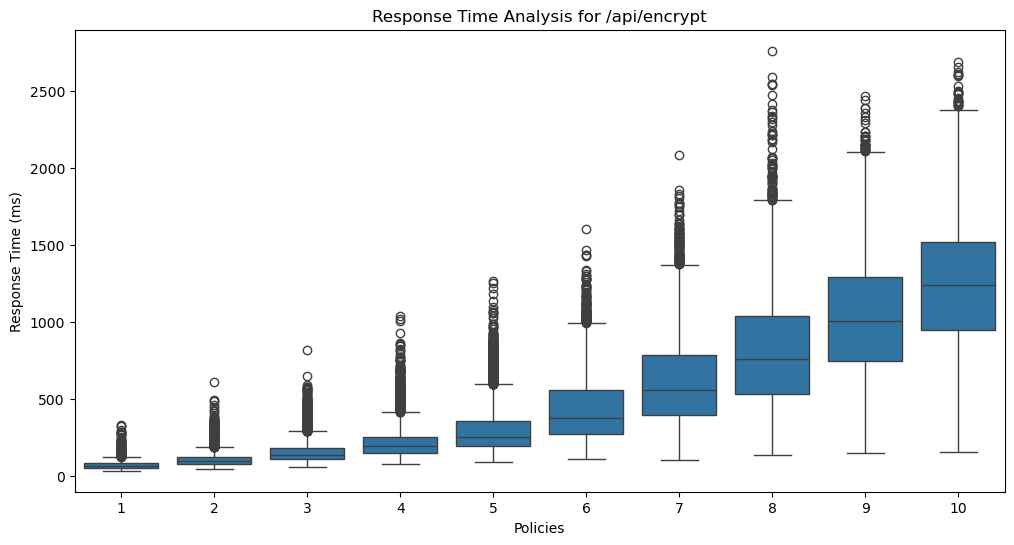

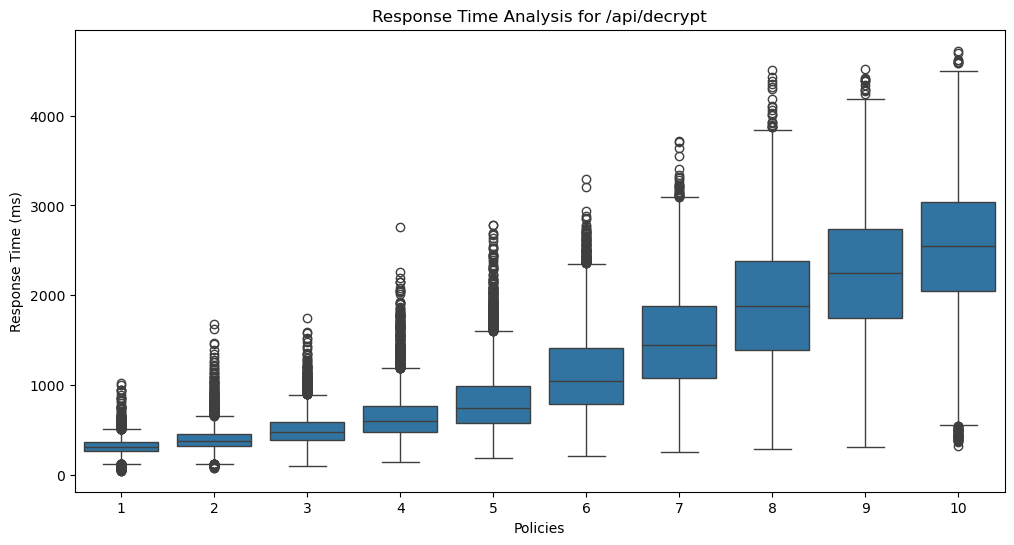

In [ ]:
## Plot response time for each policy count

data = phase4.copy()

os.makedirs("images/phase4", exist_ok=True)

endpoints = ["/api/encrypt", "/api/decrypt"]

for endpoint in endpoints:
    endpoint_data = data[data["Name"] == endpoint]

    plt.figure(figsize=(12, 6))
    sns.boxplot(x="Policies", y="Response Time (ms)", data=endpoint_data)
    plt.title(f"Response Time Analysis for {endpoint}")
    plt.xlabel("Policies")
    plt.ylabel("Response Time (ms)")

    plot_path = os.path.join("images/phase4", f"response_time_{endpoint.strip('/').replace('/', '_')}.png")
    plt.savefig(plot_path)
    plt.show()
    plt.close()

In [ ]:
## Phase 4: Summary of the results for each API endpoint

data["Start Time"] = pd.to_datetime(data["Start Time"], unit='s')
data["End Time"] = data["Start Time"] + pd.to_timedelta(data["Response Time (ms)"], unit='ms')

data = data[(data["Name"] == "/api/encrypt") | (data["Name"] == "/api/decrypt")]

summary = data.groupby(["Name", "Workers", "Threads", "Policies"]).agg(
    Min_Response_Time=("Response Time (ms)", "min"),
    Max_Response_Time=("Response Time (ms)", "max"),
    Mean_Response_Time=("Response Time (ms)", "mean"),
    Median_Response_Time=("Response Time (ms)", "median"),
    Std_Dev_Response_Time=("Response Time (ms)", "std"),
    Total_Requests=("Response Time (ms)", "count"),
    Test_Start_Time=("Start Time", "min"),
    Test_End_Time=("End Time", "max")
).reset_index()

summary["Total_Time"] = (summary["Test_End_Time"] - summary["Test_Start_Time"]).dt.total_seconds()

summary["Requests_per_Second"] = summary["Total_Requests"] / summary["Total_Time"]

summary = summary.drop(columns=["Test_Start_Time", "Test_End_Time", "Total_Time"])

summary.to_csv("images/phase4/summary.csv", index=False)

summary

,Name,Workers,Threads,Policies,Min_Response_Time,Max_Response_Time,Mean_Response_Time,Median_Response_Time,Std_Dev_Response_Time,Total_Requests,Requests_per_Second
0,/api/decrypt,25,1,1,49.017,1029.799,320.492573,313.8610,92.425633,7557,12.701810
1,/api/decrypt,25,1,2,77.033,1684.684,403.993742,383.2470,134.057433,7254,12.169496
2,/api/decrypt,25,1,3,102.946,1742.501,507.810128,478.4510,169.110683,7159,12.002343
3,/api/decrypt,25,1,4,140.974,2760.517,653.580042,603.1740,261.602630,6745,11.341439
4,/api/decrypt,25,1,5,193.317,2778.973,827.549203,749.2760,353.175731,6341,10.692538
5,/api/decrypt,25,1,6,212.713,3294.781,1140.064996,1045.3460,474.882083,6039,10.327282
6,/api/decrypt,25,1,7,261.642,3716.612,1507.693601,1442.5035,565.897223,5618,9.617253
7,/api/decrypt,25,1,8,289.374,4506.411,1910.261387,1877.6645,676.904056,5118,8.759849
8,/api/decrypt,25,1,9,307.486,4513.452,2255.543602,2246.6690,699.295685,4757,8.226144
9,/api/decrypt,25,1,10,328.121,4721.203,2537.629215,2543.6110,722.198453,4484,7.700030


In [87]:
## Payload size analysis

size_analysis_data = load_and_process_files("./test_results/20250402_212332T10m")

size_analysis_data = size_analysis_data[size_analysis_data["Name"] == "/api/encrypt"]


size_analysis_data["Payload Size"] = size_analysis_data["Payload Size"].astype(int)
size_analysis_data["Cryptographed Payload Size (bytes)"] = size_analysis_data["Cryptographed Payload Size (bytes)"].astype(int)
size_analysis_data["Cryptographed Key Size (bytes)"] = size_analysis_data["Cryptographed Key Size (bytes)"].astype(int)

size_analysis_data = size_analysis_data[["Payload Size", "Cryptographed Payload Size (bytes)"]].drop_duplicates()



os.makedirs("images/size_analysis", exist_ok=True)

size_analysis_data.to_csv("images/size_analysis/payload_size_analysis.csv", index=False)
size_analysis_data


,Payload Size,Cryptographed Payload Size (bytes)
40,32768,87477
15370,16384,43785
30856,1024,2825
46306,4096,11017
61794,262144,699145
77114,65536,174857


([<matplotlib.axis.XTick at 0x77dcb6301880>,
 [Text(1024, 0, '1024'),
  Text(4096, 0, '4096'),
  Text(16384, 0, '16384'),
  Text(32768, 0, '32768'),
  Text(65536, 0, '65536'),
  Text(262144, 0, '262144')])

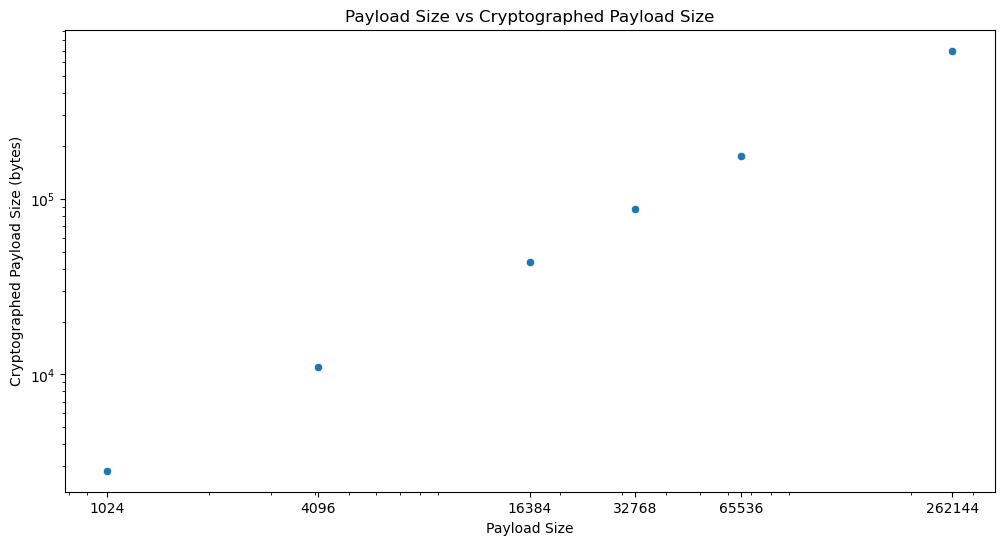

In [86]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x="Payload Size", y="Cryptographed Payload Size (bytes)", data=size_analysis_data)
plt.title("Payload Size vs Cryptographed Payload Size")
plt.xlabel("Payload Size")
plt.ylabel("Cryptographed Payload Size (bytes)")
plt.xscale("log")
plt.yscale("log")
payload_sizes = sorted(size_analysis_data["Payload Size"].unique())
plt.xticks(payload_sizes, labels=[f"{size}" for size in payload_sizes], minor=False)

In [95]:
## User key size vs number of attributes
attributes_size_analysis_data = load_and_process_files("./test_results/20250403_003152T30m")
attributes_size_analysis_data = attributes_size_analysis_data[attributes_size_analysis_data["Name"] == "/api/keygen"]
attributes_size_analysis_data["User Key Size (bytes)"] = attributes_size_analysis_data["User Key Size (bytes)"].astype(int)
attributes_size_analysis_data["User Attributes"] = attributes_size_analysis_data["User Attributes"].astype(int)

# show uniquie values of User Key Size (bytes) and User Attributes
attributes_size_analysis_data = attributes_size_analysis_data[["User Key Size (bytes)", "User Attributes"]].drop_duplicates()

# calculate the mean user key size for each user attributes number
attributes_size_analysis_data = attributes_size_analysis_data.groupby("User Attributes").agg(
    Mean_User_Key_Size=("User Key Size (bytes)", "mean")
).reset_index()

# round mean_user_key_size to int
attributes_size_analysis_data["Mean_User_Key_Size"] = attributes_size_analysis_data["Mean_User_Key_Size"].round().astype(int)

attributes_size_analysis_data


,User Attributes,Mean_User_Key_Size
0,1,512
1,2,820
2,3,1110
3,4,1394
4,5,1671
...,...,...
96,97,24696
97,98,24944
98,99,25189
99,100,25431


<module 'matplotlib.pyplot' from '/usr/lib/python3/dist-packages/matplotlib/pyplot.py'>

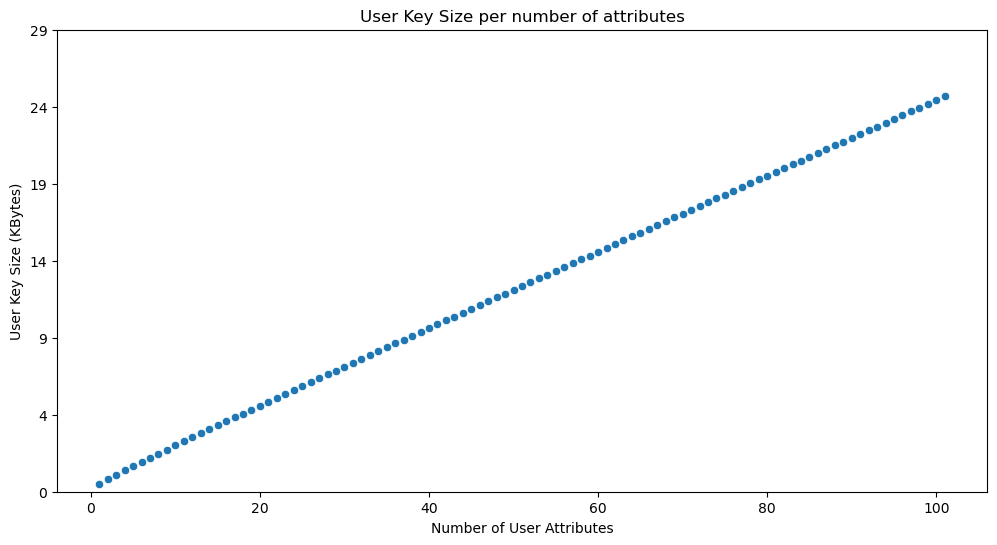

In [108]:


## plot user key size by number of user attributes
plt.figure(figsize=(12, 6))
sns.scatterplot(x="User Attributes", y="Mean_User_Key_Size", data=attributes_size_analysis_data)
plt.title(f"User Key Size per number of attributes")
plt.xlabel("Number of User Attributes")
plt.ylabel("User Key Size (KBytes)")
yticks, ylabels = plt.yticks()
plt.yticks(
  ticks=yticks,
  labels=[f"{int(label.get_text()) // 1024}" if label.get_text().isdigit() or label.get_text().lstrip('-').isdigit() else label for label in ylabels]
)

# only plot from y = 0
plt.gca().set_ylim(bottom=0)

os.makedirs("images/key_size_analysis", exist_ok=True)
plt.savefig("images/key_size_analysis/user_key_size_analysis.png")

plt